In [ ]:
# # paraphrased label
# category = {}

# for i in tqdm(range(len(df)), desc="Processing rows"):
#     chatgpt = df.iloc[i]["paraphrases"][1:-1].split(', ')
#     for j in chatgpt[:1]: # take the first paraphrased text
#         category[j[1:-1]] = 1  # gpt
#     category[df.iloc[i]['text']] = 0  # human

In [ ]:
# paraphrases_df = df['paraphrases'].apply(pd.Series).stack().reset_index(level=1, drop=True)
# paraphrases_df.name = 'text'
# paraphrases_df = paraphrases_df.to_frame()
# paraphrases_df['label'] = 1  # AI-generated text
# paraphrases_df

In [ ]:
# human_text_df = df[['text']].copy()
# human_text_df['label'] = 0  # Human-authored text
# human_text_df

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from scipy.sparse import hstack
from tqdm import tqdm

### Format Data & Add Label

In [3]:
%%time
# load
df = pd.read_csv('chatgpt_paraphrases.csv')
df = df[df['source'] == 'cnn_news'].reset_index(drop = True) # filter for cnn_news text
df['paraphrases_list'] = df['paraphrases'].apply(ast.literal_eval) # convert stings to lists
df['paraphrase'] = df['paraphrases_list'].apply(lambda x: x[0]) # select the first pharaphrased sentence
df = df[['text', 'paraphrase']]
print(df.shape)
df.head(10)

(80076, 2)
Wall time: 4.12 s


,text,paraphrase
0,"Matt Chorley, Mailonline Political Editor .",The Political Editor of Mailonline is Matt Cho...
1,Universities minister David Willetts said all ...,"According to David Willetts, universities can ..."
2,Universities cannot be expected to march forei...,"David Willetts, a senior Tory minister, cautio..."
3,The universities minister told MailOnline lect...,"According to MailOnline, the universities mini..."
4,But he insisted they cannot be forced to track...,He maintained that they cannot be compelled to...
5,It puts him at odds with Home Secretary Theres...,Home Secretary Theresa May disagrees with him ...
6,"Official figures suggest that around 100,000 f...","According to official statistics, approximatel..."
7,According to the Office for National Statistic...,The Office for National Statistics reported th...
8,"Yet last year, only 50,000 non-EU students ret...","However, only 50,000 non-EU students went back..."
9,Mrs May wants the Tory manifesto to include a ...,Mrs May desires the Conservative Party's manif...


In [4]:
%%time
# Human-authored text
df_text = pd.DataFrame({
    'text': df['text'],
    'label': 0
})

# AI-generated text
df_paraphrase = pd.DataFrame({
    'text': df['paraphrase'],
    'label': 1
})

combined_df = pd.concat([df_text, df_paraphrase], axis=0).reset_index(drop=True)
combined_df['label'].value_counts()

Wall time: 16.1 ms


0    80076
1    80076
Name: label, dtype: int64

In [39]:
# combined_df.iloc[1,0]

'universities minister david willetts say universities ask students book flight home'

In [ ]:
# combined_df.iloc[80077,0]

In [41]:
# combined_df.head(10)

In [ ]:
# combined_df.iloc[80076:].head(10)

In [5]:
combined_df['text']

0               Matt Chorley, Mailonline Political Editor .
1         Universities minister David Willetts said all ...
2         Universities cannot be expected to march forei...
3         The universities minister told MailOnline lect...
4         But he insisted they cannot be forced to track...
                                ...                        
160147    He desires a reduction in prices across all ca...
160148    The Department for Environment, Food and Rural...
160149    Downing Street is expected to reveal specifics...
160150    In a speech last month, Chancellor George Osbo...
160151    Yesterday, Mr Miliband warned that the industr...
Name: text, Length: 160152, dtype: object

### Preprocessing

In [6]:
# data cleaning functions
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r' ', string)

def clean_sentence(sentence):
    sentence = re.sub(r'http\S+', ' ', sentence) # remove URLS 
    sentence = remove_emoji(sentence) # remove emoji's
    sentence = re.sub("[^0-9A-Za-z ]", "" , sentence) # remove punctuation 
    sentence = sentence.replace('  ',"") # remove double spaces    
    return sentence.strip()

def remove_stopwords(tokens, stopwords):
    clean_token = [word for word in tokens if word not in stopwords]
    return clean_token
 
def lemmatize(tokens, lemma):
    lemmatized_tokens = [lemma.lemmatize(token, pos = 'v') for token in tokens]
    return lemmatized_tokens

def processing(df, stopwords, lemma):
    df['text'] = df['text'].apply(lambda sentence: sentence.lower()) # lowercasing
    df['text'] = df['text'].apply(lambda sentence: clean_sentence(sentence)) # cleaning
    df['text'] = df['text'].apply(lambda sentence: sentence.split()) # tokenization
    df['text'] = df['text'].apply(lambda sentence: remove_stopwords(sentence, stopwords)) # remove stopwords
    df['text'] = df['text'].apply(lambda sentence: lemmatize(sentence, lemma)) # lemmalization 
    df['text'] = df['text'].apply(lambda sentence: ' '.join(sentence)) # detokenization

In [7]:
%%time
# nltk.download('stopwords')
# nltk.download('omw-1.4')
stop_words = nltk.corpus.stopwords.words('english')
lemma = WordNetLemmatizer()

processing(combined_df, stop_words, lemma)

Wall time: 12.6 s


In [8]:
combined_df['text']

0                  matt chorley mailonline political editor
1         universities minister david willetts say unive...
2         universities cannot expect march foreign stude...
3         universities minister tell mailonline lecturer...
4         insist cannot force track course end escort ai...
                                ...                        
160147    desire reduction price across categories poten...
160148    department environment food rural affairs plan...
160149    down street expect reveal specifics water bill...
160150    speech last month chancellor george osborne in...
160151    yesterday mr miliband warn industry would exem...
Name: text, Length: 160152, dtype: object

### Feature Extraction

In [9]:
%%time
# bow
count_vectorizer = CountVectorizer()
X_count = count_vectorizer.fit_transform(combined_df['text'])
X_count.shape

Wall time: 1.53 s


(160152, 63072)

In [10]:
# bow_df = pd.DataFrame(X_count[:10].toarray(), columns=count_vectorizer.get_feature_names_out())
# first = bow_df.iloc[0]

# non_zero = []

# for column, value in first.iteritems():
#     if value != 0:
#         non_zero.append((column, value))

# print("Non-zero cells in the first row:", non_zero)

In [11]:
%%time
# tfidf
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(combined_df['text'])
X_tfidf.shape

Wall time: 1.57 s


(160152, 63072)

In [12]:
# tfidf_df = pd.DataFrame(X_tfidf[:10].toarray(), columns=tfidf.get_feature_names_out())
# first_row = tfidf_df.iloc[0]

# non_zero_cells = []

# for column, value in first_row.iteritems():
#     if value != 0:
#         non_zero_cells.append((column, value))

# print("Non-zero cells in the first row:", non_zero_cells)

### Train Test Split

In [13]:
# feature df
X_nb = hstack([X_count])
X_lr = hstack([X_count, X_tfidf])
print('NB:', X_nb.shape)
print('LR:', X_lr.shape)

NB: (160152, 63072)
LR: (160152, 126144)


In [14]:
y = combined_df['label']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_nb, y, test_size=0.2, random_state=42)

In [16]:
# X_train.shape

In [17]:
X_tr, X_te, y_tr, y_te = train_test_split(X_lr, y, test_size=0.2, random_state=42)

In [18]:
# X_tr.shape

In [19]:
# y_train
# y_test

### Classification - Naive Bayes

In [32]:
%%time
# a = 1
naive_bayes_model = MultinomialNB()
naive_bayes_model.fit(X_train, y_train)

Wall time: 25.3 ms


MultinomialNB()

In [33]:
# a = 1
naive_bayes_pred = naive_bayes_model.predict(X_test)
naive_bayes_score = naive_bayes_model.predict_proba(X_test)
print(f'Accuracy: {accuracy_score(y_test, naive_bayes_pred)}')
print(f'AUROC: {roc_auc_score(y_test, naive_bayes_pred)}')
print(f'Preicision: {precision_score(y_test, naive_bayes_pred)}')
print(f'Recall: {recall_score(y_test, naive_bayes_pred)}')
print(f'F1 Score: {f1_score(y_test, naive_bayes_pred)}')
print(confusion_matrix(y_test, naive_bayes_pred))
print(classification_report(y_test, naive_bayes_pred))

Accuracy: 0.7298866722862227
AUROC: 0.7298198906648222
Preicision: 0.7293426367976497
Recall: 0.738015607580825
F1 Score: 0.7336534909493904
[[11463  4422]
 [ 4230 11916]]
              precision    recall  f1-score   support

           0       0.73      0.72      0.73     15885
           1       0.73      0.74      0.73     16146

    accuracy                           0.73     32031
   macro avg       0.73      0.73      0.73     32031
weighted avg       0.73      0.73      0.73     32031



In [56]:
%%time
# a = 30
param_grid = {#'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 100]
              'alpha': np.linspace(10,100,10)
             }
gs_nb = GridSearchCV(MultinomialNB(), param_grid, cv=10, scoring = 'accuracy') 
gs_nb.fit(X_train, y_train)

naive_bayes_model = gs_nb.best_estimator_
print(gs_nb.best_params_)
naive_bayes_model

{'alpha': 30.0}
Wall time: 2.77 s


MultinomialNB(alpha=30.0)

In [35]:
# a = 30
naive_bayes_pred = naive_bayes_model.predict(X_test)
naive_bayes_score = naive_bayes_model.predict_proba(X_test)
print(f'Accuracy: {accuracy_score(y_test, naive_bayes_pred)}')
print(f'AUROC: {roc_auc_score(y_test, naive_bayes_pred)}')
print(f'Preicision: {precision_score(y_test, naive_bayes_pred)}')
print(f'Recall: {recall_score(y_test, naive_bayes_pred)}')
print(f'F1 Score: {f1_score(y_test, naive_bayes_pred)}')
print(confusion_matrix(y_test, naive_bayes_pred))
print(classification_report(y_test, naive_bayes_pred))

Accuracy: 0.7678498954138179
AUROC: 0.7681743678171811
Preicision: 0.7940580688723835
Recall: 0.7283537718320326
F1 Score: 0.7597880863160614
[[12835  3050]
 [ 4386 11760]]
              precision    recall  f1-score   support

           0       0.75      0.81      0.78     15885
           1       0.79      0.73      0.76     16146

    accuracy                           0.77     32031
   macro avg       0.77      0.77      0.77     32031
weighted avg       0.77      0.77      0.77     32031



### Classification - Logistic Regression

In [50]:
%%time
# C = 1
logistic_model = LogisticRegression(solver = 'lbfgs', verbose = 2, n_jobs = -1)
logistic_model.fit(X_tr, y_tr)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished


Wall time: 3.37 s


LogisticRegression(n_jobs=-1, verbose=2)

In [51]:
# C = 1
logistic_pred = logistic_model.predict(X_te)
logistic_score = logistic_model.predict_proba(X_te)
print(f'Accuracy: {accuracy_score(y_te, logistic_pred)}')
print(f'AUROC: {roc_auc_score(y_te, logistic_pred)}')
print(f'Preicision: {precision_score(y_te, logistic_pred)}')
print(f'Recall: {recall_score(y_te, logistic_pred)}')
print(f'F1 Score: {f1_score(y_te, logistic_pred)}')
print(confusion_matrix(y_te, logistic_pred))
print(classification_report(y_te, logistic_pred))

Accuracy: 0.7530517311354625
AUROC: 0.7530963913215423
Preicision: 0.7588960140827361
Recall: 0.7476155084850737
F1 Score: 0.7532135280169725
[[12050  3835]
 [ 4075 12071]]
              precision    recall  f1-score   support

           0       0.75      0.76      0.75     15885
           1       0.76      0.75      0.75     16146

    accuracy                           0.75     32031
   macro avg       0.75      0.75      0.75     32031
weighted avg       0.75      0.75      0.75     32031



In [57]:
%%time
# C = 0.12
param_grid_ = {#'C': [0.001, 0.01, 0.1, 1, 10, 100]
               'C': np.linspace(0.01,1,10)
              }
gs_lr = GridSearchCV(LogisticRegression(solver = 'lbfgs', verbose = 2, n_jobs = -1), 
                     param_grid_, cv=10, scoring = 'accuracy') 
gs_lr.fit(X_tr, y_tr)

logistic_model = gs_lr.best_estimator_
print(gs_lr.best_params_)
logistic_model

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend Loky

{'C': 0.12}
Wall time: 5min 18s


LogisticRegression(C=0.12, n_jobs=-1, verbose=2)

In [58]:
# C = 0.12
logistic_pred = logistic_model.predict(X_te)
logistic_score = logistic_model.predict_proba(X_te)
print(f'Accuracy: {accuracy_score(y_te, logistic_pred)}')
print(f'AUROC: {roc_auc_score(y_te, logistic_pred)}')
print(f'Preicision: {precision_score(y_te, logistic_pred)}')
print(f'Recall: {recall_score(y_te, logistic_pred)}')
print(f'F1 Score: {f1_score(y_te, logistic_pred)}')
print(confusion_matrix(y_te, logistic_pred))
print(classification_report(y_te, logistic_pred))

Accuracy: 0.7713777278261684
AUROC: 0.7714320002779173
Preicision: 0.7779247779247779
Recall: 0.7647714604236343
F1 Score: 0.7712920453480746
[[12360  3525]
 [ 3798 12348]]
              precision    recall  f1-score   support

           0       0.76      0.78      0.77     15885
           1       0.78      0.76      0.77     16146

    accuracy                           0.77     32031
   macro avg       0.77      0.77      0.77     32031
weighted avg       0.77      0.77      0.77     32031



### Random Forest Model

In [61]:
%%time
# default
rf = RandomForestClassifier(random_state=42, verbose = 2, n_jobs = -1)
rf.fit(X_tr, y_tr)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100

building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.4min


building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.7min finished


RandomForestClassifier(n_jobs=-1, random_state=42, verbose=2)

In [62]:
# default
rf_pred = rf.predict(X_te)
rf_score = rf.predict_proba(X_te)
print(f'Accuracy: {accuracy_score(y_te, rf_pred)}')
print(f'AUROC: {roc_auc_score(y_te, rf_pred)}')
print(f'Preicision: {precision_score(y_te, rf_pred)}')
print(f'Recall: {recall_score(y_te, rf_pred)}')
print(f'F1 Score: {f1_score(y_te, rf_pred)}')
print(confusion_matrix(y_te, rf_pred))
print(classification_report(y_te, rf_pred))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s


Accuracy: 0.7474009553245293
AUROC: 0.7477207626302343
Preicision: 0.77170613236187
Recall: 0.7084726867335563
F1 Score: 0.7387387387387387
[[12501  3384]
 [ 4707 11439]]
              precision    recall  f1-score   support

           0       0.73      0.79      0.76     15885
           1       0.77      0.71      0.74     16146

    accuracy                           0.75     32031
   macro avg       0.75      0.75      0.75     32031
weighted avg       0.75      0.75      0.75     32031



[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.5s finished


In [66]:
%%time
# tune
param_grid__ = {
    'n_estimators': [100, 200, 300, 400],  # Number of trees in the forest
    'max_depth': [2, 5, 10, 20, 40, None]        # Maximum depth of the trees
}

gs_rf = GridSearchCV(estimator=rf, param_grid=param_grid__, cv=3, n_jobs=-1, verbose=2)
gs_rf.fit(X_tr, y_tr)

rf_model = gs_rf.best_estimator_
print(gs_lr.best_params_)
rf_model

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 400building tree 2 of 400
building tree 3 of 400

building tree 4 of 400
building tree 5 of 400
building tree 6 of 400
building tree 7 of 400
building tree 8 of 400
building tree 9 of 400
building tree 10 of 400
building tree 11 of 400
building tree 12 of 400
building tree 13 of 400
building tree 14 of 400
building tree 15 of 400
building tree 16 of 400
building tree 17 of 400
building tree 18 of 400
building tree 19 of 400
building tree 20 of 400
building tree 21 of 400
building tree 22 of 400
building tree 23 of 400
building tree 24 of 400
building tree 25 of 400
building tree 26 of 400
building tree 27 of 400
building tree 28 of 400


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.7s


building tree 29 of 400
building tree 30 of 400
building tree 31 of 400
building tree 32 of 400
building tree 33 of 400
building tree 34 of 400
building tree 35 of 400
building tree 36 of 400
building tree 37 of 400
building tree 38 of 400
building tree 39 of 400
building tree 40 of 400
building tree 41 of 400
building tree 42 of 400
building tree 43 of 400
building tree 44 of 400
building tree 45 of 400
building tree 46 of 400
building tree 47 of 400
building tree 48 of 400
building tree 49 of 400
building tree 50 of 400
building tree 51 of 400
building tree 52 of 400
building tree 53 of 400
building tree 54 of 400
building tree 55 of 400
building tree 56 of 400
building tree 57 of 400
building tree 58 of 400
building tree 59 of 400
building tree 60 of 400
building tree 61 of 400
building tree 62 of 400
building tree 63 of 400
building tree 64 of 400
building tree 65 of 400
building tree 66 of 400
building tree 67 of 400
building tree 68 of 400
building tree 69 of 400
building tree 70

[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   21.6s


building tree 147 of 400
building tree 148 of 400
building tree 149 of 400
building tree 150 of 400
building tree 151 of 400
building tree 152 of 400
building tree 153 of 400
building tree 154 of 400
building tree 155 of 400
building tree 156 of 400
building tree 157 of 400
building tree 158 of 400
building tree 159 of 400
building tree 160 of 400
building tree 161 of 400
building tree 162 of 400
building tree 163 of 400
building tree 164 of 400
building tree 165 of 400
building tree 166 of 400
building tree 167 of 400
building tree 168 of 400
building tree 169 of 400
building tree 170 of 400
building tree 171 of 400
building tree 172 of 400
building tree 173 of 400
building tree 174 of 400
building tree 175 of 400
building tree 176 of 400
building tree 177 of 400
building tree 178 of 400
building tree 179 of 400
building tree 180 of 400
building tree 181 of 400
building tree 182 of 400
building tree 183 of 400
building tree 184 of 400
building tree 185 of 400
building tree 186 of 400


[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:   52.8s


building tree 350 of 400
building tree 351 of 400
building tree 352 of 400
building tree 353 of 400
building tree 354 of 400
building tree 355 of 400
building tree 356 of 400
building tree 357 of 400
building tree 358 of 400
building tree 359 of 400
building tree 360 of 400
building tree 361 of 400
building tree 362 of 400
building tree 363 of 400
building tree 364 of 400
building tree 365 of 400
building tree 366 of 400
building tree 367 of 400
building tree 368 of 400
building tree 369 of 400
building tree 370 of 400
building tree 371 of 400
building tree 372 of 400
building tree 373 of 400
building tree 374 of 400
building tree 375 of 400
building tree 376 of 400
building tree 377 of 400
building tree 378 of 400
building tree 379 of 400
building tree 380 of 400
building tree 381 of 400
building tree 382 of 400
building tree 383 of 400
building tree 384 of 400
building tree 385 of 400
building tree 386 of 400
building tree 387 of 400
building tree 388 of 400
building tree 389 of 400


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.0min finished


RandomForestClassifier(max_depth=40, n_estimators=400, n_jobs=-1,
                       random_state=42, verbose=2)

In [68]:
# default
rf_pred = rf_model.predict(X_te)
rf_score = rf_model.predict_proba(X_te)
print(f'Accuracy: {accuracy_score(y_te, rf_pred)}')
print(f'AUROC: {roc_auc_score(y_te, rf_pred)}')
print(f'Preicision: {precision_score(y_te, rf_pred)}')
print(f'Recall: {recall_score(y_te, rf_pred)}')
print(f'F1 Score: {f1_score(y_te, rf_pred)}')
print(confusion_matrix(y_te, rf_pred))
print(classification_report(y_te, rf_pred))

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 130 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 333 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 400 out of 400 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 130 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 333 tasks      | elapsed:    0.2s


Accuracy: 0.7525834347975399
AUROC: 0.7525728576596911
Preicision: 0.7549463499348756
Recall: 0.7538709277839712
F1 Score: 0.7544082556013512
[[11934  3951]
 [ 3974 12172]]
              precision    recall  f1-score   support

           0       0.75      0.75      0.75     15885
           1       0.75      0.75      0.75     16146

    accuracy                           0.75     32031
   macro avg       0.75      0.75      0.75     32031
weighted avg       0.75      0.75      0.75     32031



[Parallel(n_jobs=16)]: Done 400 out of 400 | elapsed:    0.3s finished


### ROC Curves

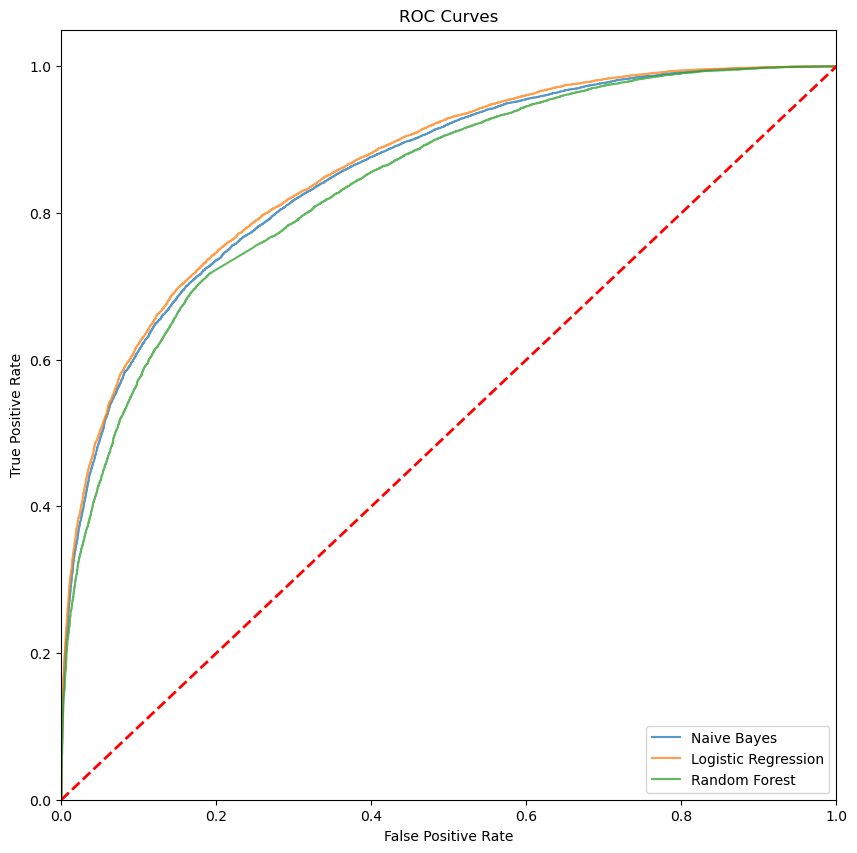

In [69]:
fpr_nb, tpr_nb, _ = roc_curve(y_test, naive_bayes_score[:, 1])
fpr_lr, tpr_lr, _ = roc_curve(y_te, logistic_score[:, 1])
fpr_rf, tpr_rf, _ = roc_curve(y_te, rf_score[:, 1])

plt.figure(figsize=(10, 10))
plt.plot(fpr_nb, tpr_nb, alpha=0.75 , label=f'Naive Bayes')
plt.plot(fpr_lr, tpr_lr, alpha=0.75 , label=f'Logistic Regression')
plt.plot(fpr_rf, tpr_rf, alpha=0.75 , label=f'Random Forest')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

In [70]:
fpr_lr

array([0.        , 0.        , 0.        , ..., 0.99118665, 0.99118665,
       1.        ])

In [71]:
# save
import pickle

# Assuming fpr_nb, tpr_nb, fpr_lr, tpr_lr, fpr_rf, tpr_rf are already defined
data_to_save = {
    'fpr_nb': fpr_nb,
    'tpr_nb': tpr_nb,
    'fpr_lr': fpr_lr,
    'tpr_lr': tpr_lr,
    'fpr_rf': fpr_rf,
    'tpr_rf': tpr_rf
}

# Save the data
with open('roc_data.pkl', 'wb') as file:
    pickle.dump(data_to_save, file)

In [72]:
# read
# Load the data
import pickle

with open('roc_data.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

# Access the data
fpr_nb_loaded = loaded_data['fpr_nb']
tpr_nb_loaded = loaded_data['tpr_nb']
fpr_lr_loaded = loaded_data['fpr_lr']
tpr_lr_loaded = loaded_data['tpr_lr']
fpr_rf_loaded = loaded_data['fpr_rf']
tpr_rf_loaded = loaded_data['tpr_rf']

In [73]:
fpr_lr_loaded

array([0.        , 0.        , 0.        , ..., 0.99118665, 0.99118665,
       1.        ])